# Access Computation

This tutorial demonstrates how to compute access.

## Setup

In [ ]:
import sys

! {sys.executable} -m pip install --quiet numpy --upgrade
! {sys.executable} -m pip install --quiet plotly

# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryCorePy==0.1.9
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryMathematicsPy==0.1.5
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryPhysicsPy==0.1.3

In [1]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

In [3]:
Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
Position = Physics.Coordinate.Position
Frame = Physics.Coordinate.Frame
Earth = Physics.Environment.Objects.CelestialBodies.Earth
Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
Access = Astrodynamics.Access

---

## Access

An access represents an object-to-object visibility period.

In this example, let's compute accesses between a fixed position on the ground and a satellite in LEO.

### Origin

Let's define a fixed ground position, using its geographic coordinates:

In [4]:
latitude = Angle.Degrees(37.0)
longitude = Angle.Degrees(-122.0)
altitude = Length.Meters(0.0)

In [5]:
from_lla = LLA(latitude, longitude, altitude)

And derive a trajectory, fixed at that position:

In [6]:
from_trajectory = Trajectory.Position(Position.Meters(from_lla.toCartesian(Earth.EquatorialRadius, Earth.Flattening), Frame.ITRF())) ;

### Target

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

First, we need a **Two-Line Element** (TLE) set:

In [7]:
tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
                            "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")

To setup a **SGP4** orbital model:

In [8]:
orbital_model = Orbit.Models.SGP4(tle)

We then obtain the satellite orbit (which is a trajectory):

In [9]:
satellite_orbit = Orbit(orbital_model)

### Access

Now that the origin and the target trajectories is well defined, we can compute the access.

Let's first define an **interval of interest**:

In [10]:
start_instant = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime(2018, 1, 3, 0, 0, 0), Scale.UTC) ;

interval = Interval.Closed(start_instant, end_instant) ;

And setup an environment (which describes where planets are, etc...):

In [11]:
environment = Physics.Environment.Default() ;

Then, using an **Access Generator**, we can compute the accesses within the intervals of interest:

In [33]:
access_generator = Access.Generator(environment) ;

accesses = access_generator.computeAccesses(interval, from_trajectory, satellite_orbit) ;

And format the output using a dataframe:

In [55]:
accesses_df = pd.DataFrame([[str(access.getType()), repr(access.getAcquisitionOfSignal()), repr(access.getTimeOfClosestApproach()), repr(access.getLossOfSignal()), repr(access.getDuration())] for access in accesses], columns=['Type', 'AOS', 'TCA', 'LOS', 'Duration'])

In [56]:
accesses_df.head()

,Type,AOS,TCA,LOS,Duration
0,Complete,2018-01-01 11:25:57 [UTC],2018-01-01 11:30:53 [UTC],2018-01-01 11:35:54 [UTC],09:57.000.000.000
1,Complete,2018-01-01 13:01:59 [UTC],2018-01-01 13:07:15 [UTC],2018-01-01 13:12:35 [UTC],10:36.000.000.000
2,Complete,2018-01-01 14:40:16 [UTC],2018-01-01 14:44:34 [UTC],2018-01-01 14:48:55 [UTC],08:39.000.000.000
3,Complete,2018-01-01 16:18:35 [UTC],2018-01-01 16:22:31 [UTC],2018-01-01 16:26:27 [UTC],07:52.000.000.000
4,Complete,2018-01-01 17:55:20 [UTC],2018-01-01 18:00:13 [UTC],2018-01-01 18:05:05 [UTC],09:45.000.000.000


### Output

Let's calculate the geographic coordinate of the satellite, during access:

In [57]:
def lla_state (state):
    
    lla = LLA.Cartesian(state.accessPosition().inFrame(Frame.ITRF(), state.accessInstant()).getCoordinates(), Earth.EquatorialRadius, Earth.Flattening)
    
    return [float(lla.getLatitude().inDegrees()), float(lla.getLongitude().inDegrees()), float(lla.getAltitude().inMeters())]

def access_geometry (access):
    
    return [lla_state(state) for state in satellite_orbit.getStatesAt(access.getInterval().generateGrid(Duration.Minutes(1.0)))]

In [58]:
access_geometry_dfs = [pd.DataFrame(access_geometry(access), columns=['Latitude', 'Longitude', 'Altitude']) for access in accesses] ;

In [59]:
access_geometry_dfs[0].head()

,Latitude,Longitude,Altitude
0,17.784709,-128.467076,405923.705438
1,20.731210,-126.014329,406414.469061
2,23.632504,-123.456078,406980.252557
3,26.479522,-120.772895,407609.567643
4,29.262056,-117.943822,408289.960043


And plot the geometries onto a map:

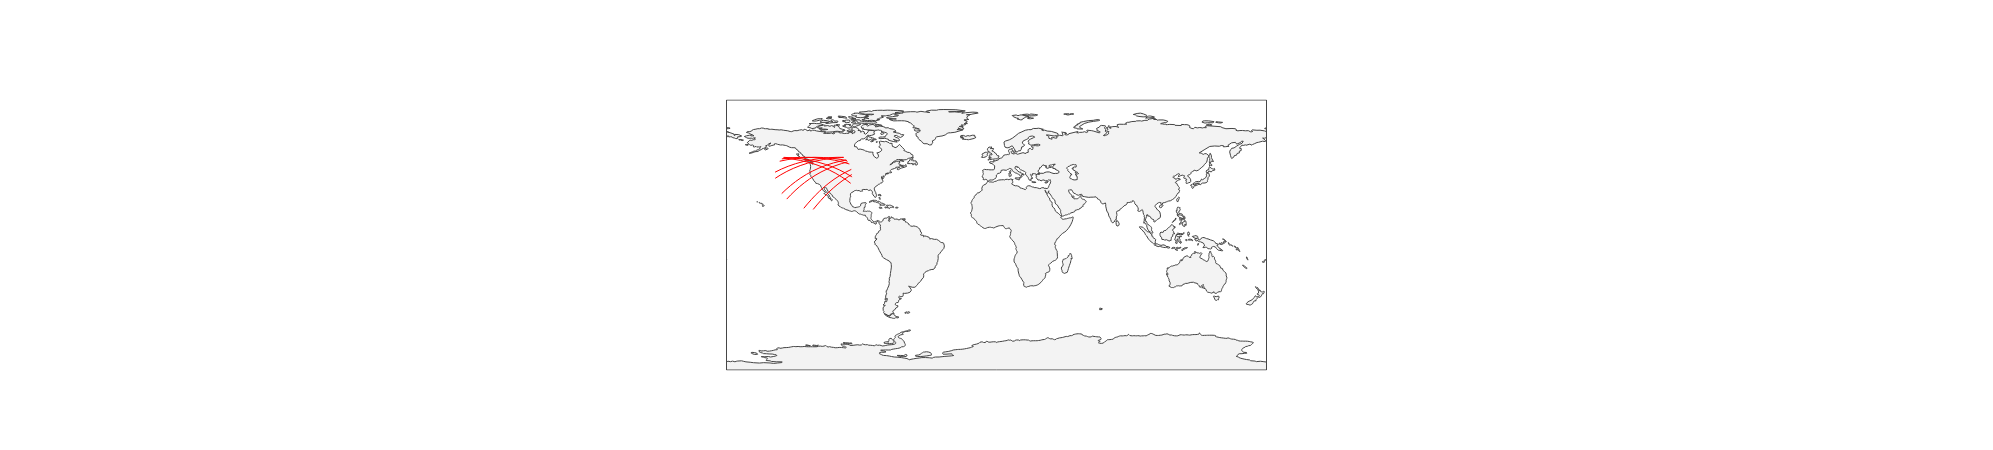

In [60]:
access_paths = []

for access_geometry_df in access_geometry_dfs:
    
    access_paths.append(
        dict(
            type = 'scattergeo',
            lon = access_geometry_df['Longitude'],
            lat = access_geometry_df['Latitude'],
            mode = 'lines',
            line = dict(
                width = 1,
                color = 'red',
            )
        )
    )
    
layout = dict(
        title = None,
        showlegend = False, 
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=access_paths, layout=layout)
iplot(fig)